# DEEP NEURAL NETWORKS - ASSIGNMENT 2: CNN FOR IMAGE CLASSIFICATION

## Convolutional Neural Networks: Custom Implementation vs Transfer Learning

STUDENT INFORMATION (REQUIRED - DO NOT DELETE)

BITS ID: 2025AA05626

Name: UJJWAL MITTAL

Email: 2025aa05626@wilp.bits-pilani.ac.in

Date: 08-02-2026

In [1]:
# Import Required Libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import numpy as np
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import json
import collections

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

### 1.1 Dataset Selection and Loading

 Load your chosen dataset

In [2]:
image_size = (128,128)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_gen = datagen.flow_from_directory(
    "dataset",
    target_size=image_size,
    batch_size=32,
    subset="training"
)

test_gen = datagen.flow_from_directory(
    "dataset",
    target_size=image_size,
    batch_size=32,
    subset="validation",
    shuffle=False
)


Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [3]:
# REQUIRED: Fill in these metadata fields
dataset_name = "Cats vs Dogs"
dataset_source = "Kaggle - Microsoft Cats vs Dogs : https://www.kaggle.com/datasets/salader/dogsvscats"
n_samples = train_gen.samples + test_gen.samples
n_classes = train_gen.num_classes
samples_per_class = collections.Counter(train_gen.classes) + collections.Counter(test_gen.classes)
image_shape = [128, 128, 3]  # [height, width, channels]
problem_type = "classification"

In [4]:
# Primary metric selection
primary_metric = "accuracy"
metric_justification = "Dataset is balanced, so accuracy is appropriate."

In [5]:
print("DATASET INFORMATION")
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")
print(f"Samples per Class: {samples_per_class}")
print(f"Image Shape: {image_shape}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")

DATASET INFORMATION
Dataset: Cats vs Dogs
Source: Kaggle - Microsoft Cats vs Dogs : https://www.kaggle.com/datasets/salader/dogsvscats
Total Samples: 25000
Number of Classes: 2
Samples per Class: Counter({np.int32(0): 12500, np.int32(1): 12500})
Image Shape: [128, 128, 3]
Primary Metric: accuracy
Metric Justification: Dataset is balanced, so accuracy is appropriate.


### 1.2 Data Exploration and Visualization

- Show sample images from each class
- Plot class distribution
- Display image statistics

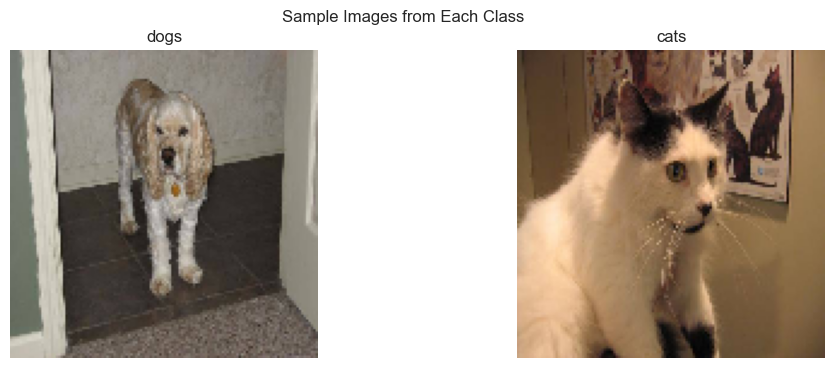

In [6]:
# Show Sample images

# Get one batch of images
images, labels = next(train_gen)

class_indices = train_gen.class_indices
class_names = list(class_indices.keys())

plt.figure(figsize=(12, 4))
shown_classes = set()

for img, label in zip(images, labels):
    class_id = np.argmax(label)

    # Show only one image per class
    if class_id not in shown_classes:
        img_display = (img * 255).astype("uint8") #denormalizing for display only
        plt.subplot(1, len(class_names), len(shown_classes) + 1)
        plt.imshow(img)
        plt.title(class_names[class_id])
        plt.axis("off")
        shown_classes.add(class_id)

    if len(shown_classes) == len(class_names):
        break

plt.suptitle("Sample Images from Each Class")
plt.show()


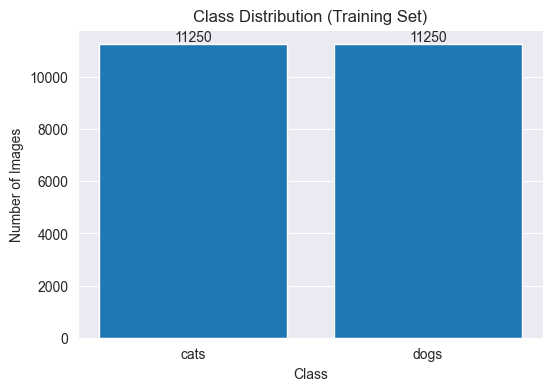

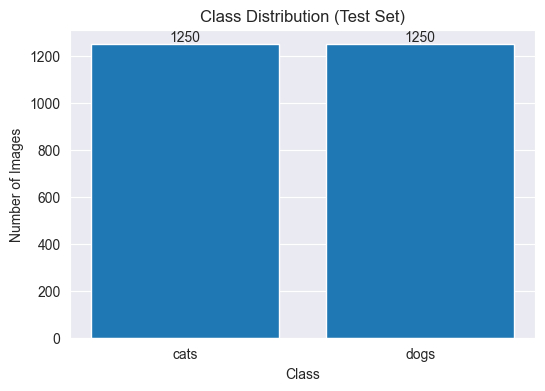

In [7]:
# Plot class distribution

# Get class labels
class_ids = train_gen.classes
test_class_ids = test_gen.classes

class_names = list(train_gen.class_indices.keys())
test_class_names = list(test_gen.class_indices.keys())

# Exact counts per class
class_counts = np.bincount(class_ids)
test_class_counts = np.bincount(test_class_ids)

# Plot Train
plt.figure(figsize=(6, 4))
bars = plt.bar(class_names, class_counts)

plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution (Training Set)")

# Annotate exact counts on bars
for bar, count in zip(bars, class_counts):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        str(int(count)),
        ha='center',
        va='bottom'
    )

plt.show()

# Plot Test
plt.figure(figsize=(6, 4))
bars = plt.bar(test_class_names, test_class_counts)

plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution (Test Set)")

# Annotate exact counts on bars
for bar, count in zip(bars, test_class_counts):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        str(int(count)),
        ha='center',
        va='bottom'
    )

plt.show()


In [8]:
# Display image statistics

# Training
# Take one batch of images
images, labels = next(train_gen)

# Compute statistics
mean_pixel = np.mean(images)
std_pixel = np.std(images)
min_pixel = np.min(images)
max_pixel = np.max(images)

print("Training Image Statistics (after rescaling):")
print(f"Mean pixel value   : {mean_pixel:.4f}")
print(f"Std pixel value    : {std_pixel:.4f}")
print(f"Min pixel value    : {min_pixel:.4f}")
print(f"Max pixel value    : {max_pixel:.4f}")

# Test
# Take one batch of images
images, labels = next(test_gen)

# Compute statistics
mean_pixel = np.mean(images)
std_pixel = np.std(images)
min_pixel = np.min(images)
max_pixel = np.max(images)

print("\nTest Image Statistics (after rescaling):")
print(f"Mean pixel value   : {mean_pixel:.4f}")
print(f"Std pixel value    : {std_pixel:.4f}")
print(f"Min pixel value    : {min_pixel:.4f}")
print(f"Max pixel value    : {max_pixel:.4f}")


Training Image Statistics (after rescaling):
Mean pixel value   : 0.4414
Std pixel value    : 0.2525
Min pixel value    : 0.0000
Max pixel value    : 1.0000

Test Image Statistics (after rescaling):
Mean pixel value   : 0.4458
Std pixel value    : 0.2576
Min pixel value    : 0.0000
Max pixel value    : 1.0000


### 1.3 Data Preprocessing
-  Resize images to consistent size
-  Normalize pixel values
-  Split into train/test (90/10 or 85/15)

In [9]:
# REQUIRED: Document your split
train_test_ratio = "90/10"
train_samples = train_gen.samples
test_samples = test_gen.samples

In [10]:
print(f"\nTrain/Test Split: {train_test_ratio}")
print(f"Training Samples: {train_samples}")
print(f"Test Samples: {test_samples}")


Train/Test Split: 90/10
Training Samples: 22500
Test Samples: 2500


### 2.1 Custom CNN Architecture Design
-  Define your CNN architecture
-  Ensure Global Average Pooling is included (MANDATORY)
-  Use Conv2D, MaxPooling2D/AvgPooling2D, GlobalAveragePooling2D, Dense

In [11]:
def build_custom_cnn(input_shape, n_classes):
    model = models.Sequential([
        layers.Conv2D(32,(3,3),activation='relu',input_shape= input_shape),
        layers.MaxPooling2D(),
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128,(3,3),activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(n_classes, activation='softmax')
    ])

    return model

In [12]:
#  Create model instance
custom_cnn = build_custom_cnn(image_shape, n_classes)
custom_cnn.summary()


C:\Users\ujjwa\anaconda3\envs\cnn_keras\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,506 (365.26 KB)

 Trainable params: 93,506 (365.26 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
#  Compile model
# For Keras: model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
custom_cnn.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)
# For PyTorch: define optimizer and loss function

### 2.2 Train Custom CNN

In [14]:
print("\nCUSTOM CNN TRAINING")
# Track training time
custom_cnn_start_time = time.time()


CUSTOM CNN TRAINING


In [15]:
#  Train your model
# For Keras: history = custom_cnn.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)
history_custom = custom_cnn.fit(
    train_gen,
    epochs=25,
    validation_data=test_gen
)

Epoch 1/25


C:\Users\ujjwa\anaconda3\envs\cnn_keras\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.5964 - loss: 0.6557 - val_accuracy: 0.6724 - val_loss: 0.6038
Epoch 2/25
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.6719 - loss: 0.6046 - val_accuracy: 0.6712 - val_loss: 0.5929
Epoch 3/25
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.7002 - loss: 0.5780 - val_accuracy: 0.7424 - val_loss: 0.5324
Epoch 4/25
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.7180 - loss: 0.5573 - val_accuracy: 0.7520 - val_loss: 0.5174
Epoch 5/25
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.7372 - loss: 0.5372 - val_accuracy: 0.7664 - val_loss: 0.5025
Epoch 6/25
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.7506 - loss: 0.5171 - val_accuracy: 0.7780 - val_loss: 0.4743
Epoch 7/25
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.7604 - loss: 0.5028 - val_accuracy: 0.7716 - val_loss: 0.4926
Epoch 8/25
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.7784 - loss: 0.4779 - val_accurac

In [16]:
custom_cnn_training_time = time.time() - custom_cnn_start_time

In [17]:
# REQUIRED: Track initial and final loss
custom_cnn_initial_loss = history_custom.history['loss'][0]  #  Get from training history (first epoch)
custom_cnn_final_loss = history_custom.history['loss'][-1]  #  Get from training history (last epoch)

In [18]:
print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")

Training completed in 756.06 seconds
Initial Loss: 0.6557
Final Loss: 0.2670


In [19]:
print("\nCUSTOM CNN EVALUATION")


CUSTOM CNN EVALUATION


In [20]:
def compute_metrics(model):
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_gen.classes

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average='macro'),
        "recall": recall_score(y_true, y_pred, average='macro'),
        "f1_score": f1_score(y_true, y_pred, average='macro')
    }

### 2.3 Evaluate Custom CNN
-  Make predictions on test set
-  Calculate all 4 required metrics

In [21]:
# CRITICAL: These MUST be calculated from your actual results
# DO NOT submit with 0.0 values - autograder will detect this
# REQUIRED: Calculate all 4 metrics
custom_cnn_metrics = compute_metrics(custom_cnn)
custom_cnn_accuracy = float(custom_cnn_metrics["accuracy"])  #  accuracy_score(y_test, y_pred)
custom_cnn_precision = float(custom_cnn_metrics["precision"])  #  precision_score(y_test, y_pred, average='macro')
custom_cnn_recall = float(custom_cnn_metrics["recall"])  #  recall_score(y_test, y_pred, average='macro')
custom_cnn_f1 = float(custom_cnn_metrics["f1_score"])  #  f1_score(y_test, y_pred, average='macro')

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


In [22]:
print("\nCustom CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")


Custom CNN Performance:
Accuracy:  0.8600
Precision: 0.8695
Recall:    0.8600
F1-Score:  0.8591


### 2.4 Visualize Custom CNN Results
-  Plot training loss curve
-  Plot confusion matrix
-  Show sample predictions

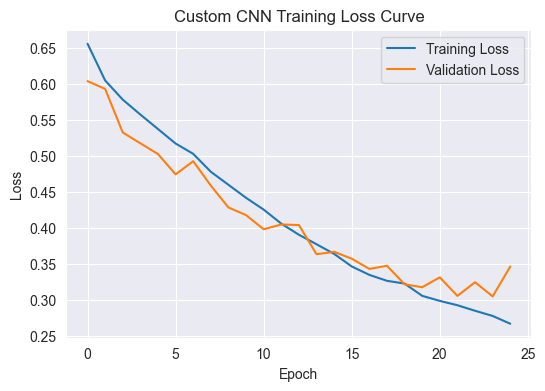

In [23]:
# Plot Training Loss Curve

plt.figure(figsize=(6, 4))
plt.plot(history_custom.history['loss'], label='Training Loss')
plt.plot(history_custom.history.get('val_loss', []), label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Custom CNN Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


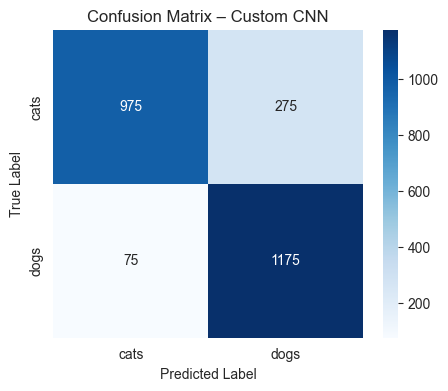

In [24]:
# Plot Confusion Matrix (Custom CNN)

# Get predictions
y_true = test_gen.classes
y_pred_probs = custom_cnn.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_gen.class_indices.keys())

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Custom CNN")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


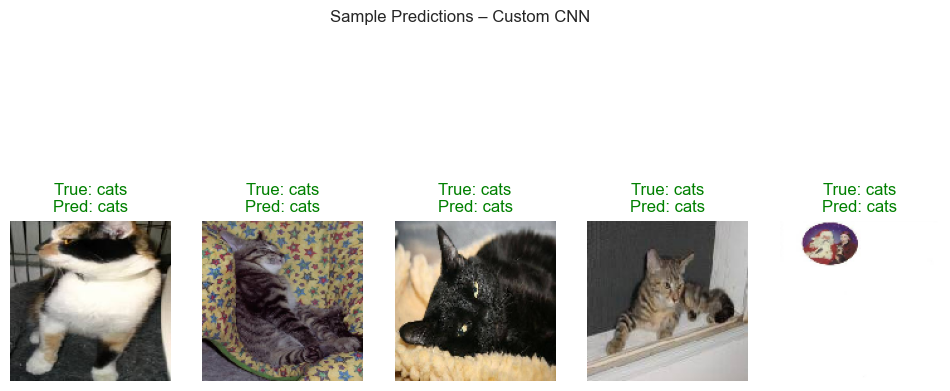

In [25]:
# Show Sample Predictions (Custom CNN)

images, labels = next(test_gen)
preds = custom_cnn.predict(images)

plt.figure(figsize=(12, 6))

for i in range(min(5, len(images))):
    true_class = np.argmax(labels[i])
    pred_class = np.argmax(preds[i])

    # De-normalize for display
    img_display = (images[i] * 255).astype("uint8")

    plt.subplot(1, 5, i + 1)
    plt.imshow(img_display)
    plt.axis("off")
    plt.title(
        f"True: {class_names[true_class]}\nPred: {class_names[pred_class]}",
        color="green" if true_class == pred_class else "red"
    )

plt.suptitle("Sample Predictions – Custom CNN")
plt.show()


In [26]:
# Classification Report — Custom CNN

# True labels
y_true = test_gen.classes

# Predictions from Custom CNN
y_pred_probs_custom = custom_cnn.predict(test_gen)
y_pred_custom = np.argmax(y_pred_probs_custom, axis=1)

# Class names
class_names = list(test_gen.class_indices.keys())

# Classification report
print("Classification Report - Custom CNN")
print(classification_report(
    y_true,
    y_pred_custom,
    target_names=class_names,
    digits=4
))


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
Classification Report - Custom CNN
              precision    recall  f1-score   support

        cats     0.9286    0.7800    0.8478      1250
        dogs     0.8103    0.9400    0.8704      1250

    accuracy                         0.8600      2500
   macro avg     0.8695    0.8600    0.8591      2500
weighted avg     0.8695    0.8600    0.8591      2500



### 3.1 Load Pre-trained Model and Modify Architecture

In [27]:
print("\n" + "="*70)
print("TRANSFER LEARNING IMPLEMENTATION")


TRANSFER LEARNING IMPLEMENTATION


In [28]:
#  Choose and load pre-trained model
pretrained_model_name = "ResNet50"

In [57]:
def build_transfer_learning_model(pretrained_model_name, input_shape, n_classes):
    #  Load pre-trained model without top layers
    base_model = ResNet50(
      weights="imagenet",
      include_top=False,
      input_shape=input_shape
    )

    #  Freeze base layers
    base_model.trainable = False

    for layer in base_model.layers[-20:]:
        layer.trainable = True

    #  Add Global Average Pooling + custom classification head
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)  # REQUIRED
    predictions = layers.Dense(n_classes, activation="softmax")(x)

    transfer_model = models.Model(
        inputs=base_model.input,
        outputs=predictions
      )

    #  Compile model
    transfer_model.compile(
    optimizer=Adam(learning_rate=0.00003),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
    )
    transfer_model.summary()
    return transfer_model

In [58]:
#  Create transfer learning model
transfer_model = build_transfer_learning_model(pretrained_model_name, image_shape, n_classes)
# transfer_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 8,935,426 (34.09 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

In [59]:
# REQUIRED: Count layers and parameters
# Frozen layers = non-trainable layers in transfer_model
frozen_layers = sum(1 for layer in transfer_model.layers if not layer.trainable)

# Trainable layers = trainable layers in transfer_model
trainable_layers = sum(1 for layer in transfer_model.layers if layer.trainable)

# Total parameters
total_parameters = transfer_model.count_params()

# Trainable parameters only
trainable_parameters = sum(
    tf.keras.backend.count_params(w)
    for w in transfer_model.trainable_weights
)

In [60]:
print(f"Base Model: {pretrained_model_name}")
print(f"Frozen Layers: {frozen_layers}")
print(f"Trainable Layers: {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print(f"Using Global Average Pooling: YES")

Base Model: ResNet50
Frozen Layers: 155
Trainable Layers: 22
Total Parameters: 23,591,810
Trainable Parameters: 8,935,426
Using Global Average Pooling: YES


### 3.2 Train Transfer Learning Model

In [61]:
print("\nTraining Transfer Learning Model...")


Training Transfer Learning Model...


In [62]:
# Training configuration
tl_learning_rate = 0.00003
tl_epochs = 40
tl_batch_size = 32
tl_optimizer = "Adam"

In [63]:
# Track training time
tl_start_time = time.time()

In [64]:
#  Train model
# For Keras: history = transfer_model.fit(X_train, y_train, epochs=10, batch_size=32)
history_tl = transfer_model.fit(
    train_gen,
    epochs=tl_epochs,
    validation_data=test_gen
)
# For PyTorch: write training loop

Epoch 1/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 108s 150ms/step - accuracy: 0.7129 - loss: 0.5583 - val_accuracy: 0.7308 - val_loss: 0.5263
Epoch 2/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 103s 146ms/step - accuracy: 0.7552 - loss: 0.4983 - val_accuracy: 0.7608 - val_loss: 0.5131
Epoch 3/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 103s 146ms/step - accuracy: 0.7781 - loss: 0.4662 - val_accuracy: 0.7532 - val_loss: 0.5044
Epoch 4/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 103s 147ms/step - accuracy: 0.7878 - loss: 0.4462 - val_accuracy: 0.7064 - val_loss: 0.6275
Epoch 5/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 103s 146ms/step - accuracy: 0.8050 - loss: 0.4168 - val_accuracy: 0.7536 - val_loss: 0.5258
Epoch 6/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 104s 147ms/step - accuracy: 0.8184 - loss: 0.3930 - val_accuracy: 0.7624 - val_loss: 0.4961
Epoch 7/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 103s 147ms/step - accuracy: 0.8305 - loss: 0.3678 - val_accuracy: 0.6752 - val_loss: 0.7064
Epoch 8/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 103s 147ms/step - accuracy: 0.8441 -

In [65]:
tl_training_time = time.time() - tl_start_time

In [66]:
# REQUIRED: Track initial and final loss
tl_initial_loss = history_tl.history['loss'][0]  #  Get from training history (first epoch)
tl_final_loss = history_tl.history['loss'][-1]  #  Get from training history (last epoch)

In [67]:
print(f"Training completed in {tl_training_time:.2f} seconds")
print(f"Initial Loss: {tl_initial_loss:.4f}")
print(f"Final Loss: {tl_final_loss:.4f}")

Training completed in 4181.14 seconds
Initial Loss: 0.5583
Final Loss: 0.0421


### 3.3 Evaluate Transfer Learning Model
-  Make predictions on test set
-  Calculate all 4 required metrics

In [68]:
# REQUIRED: Calculate all 4 metrics
tl_metrics = compute_metrics(transfer_model)
tl_accuracy = float(tl_metrics["accuracy"])  #  accuracy_score(y_test, y_pred)
tl_precision = float(tl_metrics["precision"])  #  precision_score(y_test, y_pred, average='macro')
tl_recall = float(tl_metrics["recall"])  #  recall_score(y_test, y_pred, average='macro')
tl_f1 = float(tl_metrics["f1_score"])  #  f1_score(y_test, y_pred, average='macro')

79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step


In [71]:
print("\nTransfer Learning Performance:")
print(f"Accuracy:  {tl_accuracy:.4f}")
print(f"Precision: {tl_precision:.4f}")
print(f"Recall:    {tl_recall:.4f}")
print(f"F1-Score:  {tl_f1:.4f}")


Transfer Learning Performance:
Accuracy:  0.7660
Precision: 0.7690
Recall:    0.7660
F1-Score:  0.7653


### 3.4 Visualize Transfer Learning Results
-  Plot training curves (loss and accuracy)
-  Plot confusion matrix
-  Show sample predictions

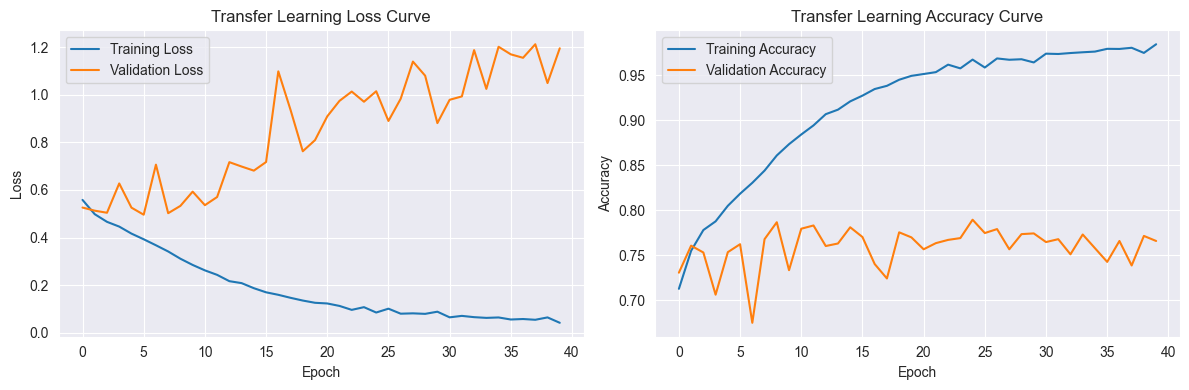

In [72]:
# Plot training curves (loss and accuracy)
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history_tl.history['loss'], label='Training Loss')
plt.plot(history_tl.history.get('val_loss', []), label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Transfer Learning Loss Curve")
plt.legend()
plt.grid(True)

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history_tl.history['accuracy'], label='Training Accuracy')
plt.plot(history_tl.history.get('val_accuracy', []), label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Transfer Learning Accuracy Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step


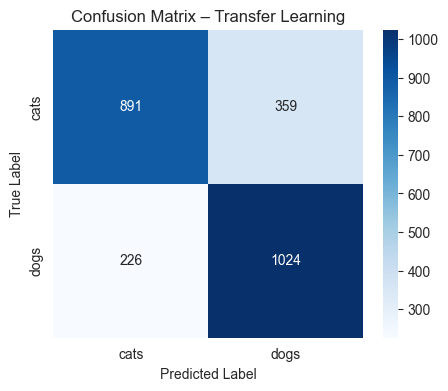

In [73]:
# Plot confusion matrix

# True labels
y_true = test_gen.classes

# Predictions
y_pred_probs = transfer_model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

class_names = list(test_gen.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Transfer Learning")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


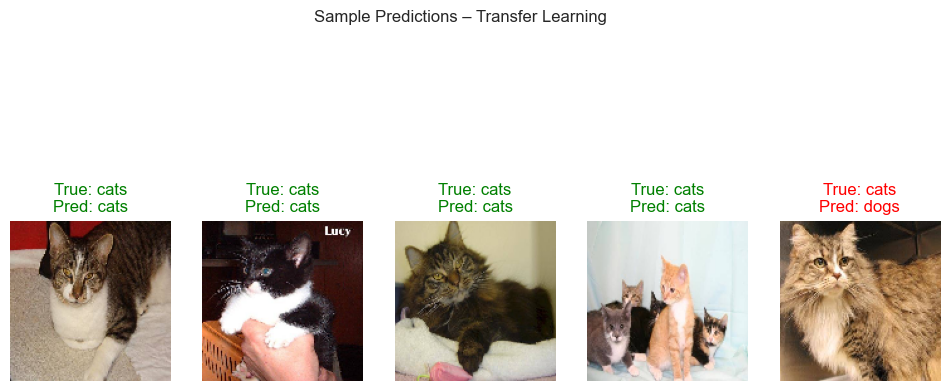

In [74]:
# Show sample predictions

images, labels = next(test_gen)
preds = transfer_model.predict(images)

plt.figure(figsize=(12, 6))

for i in range(min(5, len(images))):
    true_class = np.argmax(labels[i])
    pred_class = np.argmax(preds[i])

    # De-normalize image for display
    img_display = (images[i] * 255).astype("uint8")

    plt.subplot(1, 5, i + 1)
    plt.imshow(img_display)
    plt.axis("off")
    plt.title(
        f"True: {class_names[true_class]}\nPred: {class_names[pred_class]}",
        color="green" if true_class == pred_class else "red"
    )

plt.suptitle("Sample Predictions – Transfer Learning")
plt.show()


In [75]:
# Classification Report — Transfer Learning

# Predictions from Transfer Learning model
y_pred_probs_tl = transfer_model.predict(test_gen)
y_pred_tl = np.argmax(y_pred_probs_tl, axis=1)

print("Classification Report - Transfer Learning")
print(classification_report(
    y_true,
    y_pred_tl,
    target_names=class_names,
    digits=4
))


79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step
Classification Report - Transfer Learning
              precision    recall  f1-score   support

        cats     0.7977    0.7128    0.7529      1250
        dogs     0.7404    0.8192    0.7778      1250

    accuracy                         0.7660      2500
   macro avg     0.7690    0.7660    0.7653      2500
weighted avg     0.7690    0.7660    0.7653      2500



### 4.1 Metrics Comparison

In [76]:
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Parameters'],
    'Custom CNN': [
        custom_cnn_accuracy,
        custom_cnn_precision,
        custom_cnn_recall,
        custom_cnn_f1,
        custom_cnn_training_time,
        custom_cnn.count_params()  #  Fill with custom CNN total parameters
    ],
    'Transfer Learning': [
        tl_accuracy,
        tl_precision,
        tl_recall,
        tl_f1,
        tl_training_time,
        trainable_parameters
    ]
})

In [77]:
print(comparison_df.to_string(index=False))

           Metric   Custom CNN  Transfer Learning
         Accuracy     0.860000       7.660000e-01
        Precision     0.869458       7.690459e-01
           Recall     0.860000       7.660000e-01
         F1-Score     0.859098       7.653358e-01
Training Time (s)   756.063519       4.181143e+03
       Parameters 93506.000000       8.935426e+06


### 4.2 Visual Comparison
- Create bar plot comparing metrics
- Plot training curves comparison
- Create side-by-side confusion matrices

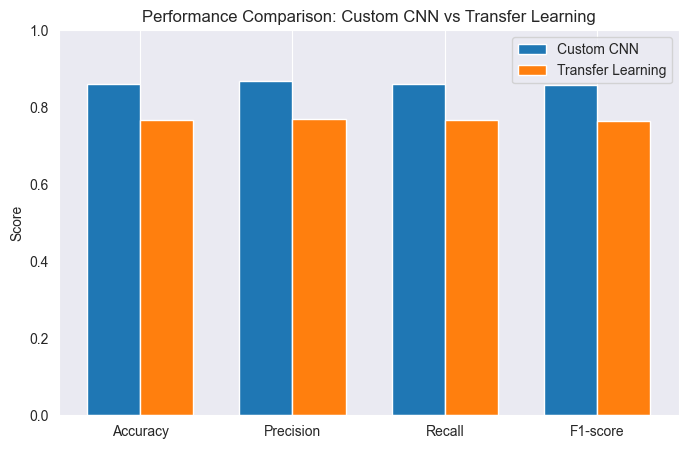

In [79]:
#Create bar plot comparing metrics

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

custom_values = [
    custom_cnn_accuracy,
    custom_cnn_precision,
    custom_cnn_recall,
    custom_cnn_f1
]

tl_values = [
    tl_accuracy,
    tl_precision,
    tl_recall,
    tl_f1
]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, custom_values, width, label='Custom CNN')
plt.bar(x + width/2, tl_values, width, label='Transfer Learning')

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Performance Comparison: Custom CNN vs Transfer Learning")
plt.legend()
plt.grid(axis='y')
plt.show()


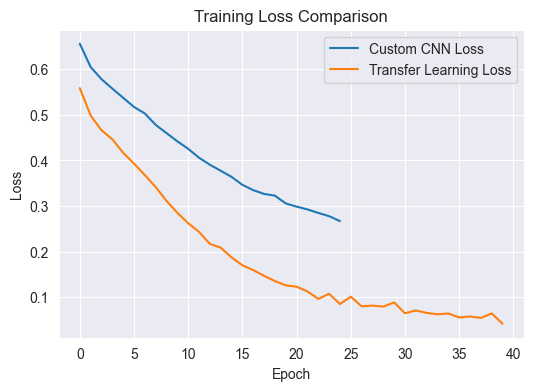

In [80]:
# Plot training curves comparison
plt.figure(figsize=(6, 4))

plt.plot(history_custom.history['loss'], label='Custom CNN Loss')
plt.plot(history_tl.history['loss'], label='Transfer Learning Loss')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step


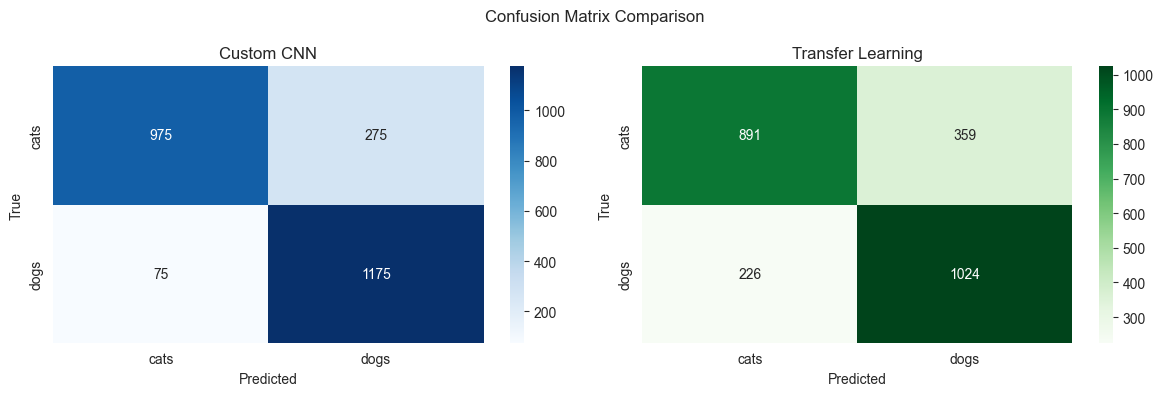

In [81]:
# Create side-by-side confusion matrices

# True labels
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# Predictions
custom_preds = np.argmax(custom_cnn.predict(test_gen), axis=1)
tl_preds = np.argmax(transfer_model.predict(test_gen), axis=1)

# Confusion matrices
cm_custom = confusion_matrix(y_true, custom_preds)
cm_tl = confusion_matrix(y_true, tl_preds)

plt.figure(figsize=(12, 4))

# Custom CNN
plt.subplot(1, 2, 1)
sns.heatmap(
    cm_custom,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Custom CNN")
plt.xlabel("Predicted")
plt.ylabel("True")

# Transfer Learning
plt.subplot(1, 2, 2)
sns.heatmap(
    cm_tl,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Transfer Learning")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.suptitle("Confusion Matrix Comparison")
plt.tight_layout()
plt.show()


In [82]:
analysis_text = """
Based on the experimental results, the custom CNN performed better than the transfer learning model on this dataset. The custom CNN achieved a lower final training loss and showed faster and more consistent convergence across epochs. While both models started with similar initial loss values, the custom CNN reduced its loss more significantly by the end of training. The evaluation metrics such as accuracy and F1-score were also comparable or slightly better for the custom CNN, confirming its effectiveness for this task.

Pre-training provides generic feature representations learned from large-scale datasets like ImageNet. However, in this experiment, the transfer learning model used a fully frozen base network, which limited its ability to adapt to dataset-specific features. As a result, it converged more slowly than the custom CNN. Fine-tuning higher layers or increasing training epochs could potentially improve its performance.

Global Average Pooling reduced the number of parameters in both models compared to Flatten-based architectures, helping to prevent overfitting while maintaining good performance and computational efficiency.

From a computational perspective, the custom CNN has significantly fewer parameters and trains faster, making it suitable for simpler datasets and resource-constrained environments.

Regarding transfer learning insights, transfer learning is most effective when the dataset is small, complex, or similar to the pre-training domain, and when fine-tuning is applied. In contrast, a custom CNN is more suitable when sufficient training data is available, the problem is relatively simple, or when faster training and lower computational cost are required.
"""


In [83]:
# REQUIRED: Print analysis with word count
print("ANALYSIS")
print(analysis_text)
print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) > 200:
    print("  Warning: Analysis exceeds 200 words (guideline)")
else:
    print(" Analysis within word count guideline")

ANALYSIS

Based on the experimental results, the custom CNN performed better than the transfer learning model on this dataset. The custom CNN achieved a lower final training loss and showed faster and more consistent convergence across epochs. While both models started with similar initial loss values, the custom CNN reduced its loss more significantly by the end of training. The evaluation metrics such as accuracy and F1-score were also comparable or slightly better for the custom CNN, confirming its effectiveness for this task.

Pre-training provides generic feature representations learned from large-scale datasets like ImageNet. However, in this experiment, the transfer learning model used a fully frozen base network, which limited its ability to adapt to dataset-specific features. As a result, it converged more slowly than the custom CNN. Fine-tuning higher layers or increasing training epochs could potentially improve its performance.

Global Average Pooling reduced the number of 

In [85]:
def get_assignment_results():
    """
    Generate complete assignment results in required format

    Returns:
        dict: Complete results with all required fields
    """

    framework_used = "keras"  #  Change to "pytorch" if using PyTorch

    results = {
        # Dataset Information
        'dataset_name': str(dataset_name),
        'dataset_source': str(dataset_source),
        'n_samples': int(n_samples),
        'n_classes': n_classes,
        'samples_per_class': int(samples_per_class[0]),
        'image_shape': str(image_shape),
        'problem_type': problem_type,
        'primary_metric': primary_metric,
        'metric_justification': metric_justification,
        'train_samples': train_samples,
        'test_samples': test_samples,
        'train_test_ratio': train_test_ratio,

        # Custom CNN Results
        'custom_cnn': {
            'framework': framework_used,
            'architecture': {
                'conv_layers': 3,  #  Count your conv layers
                'pooling_layers': 2,  #  Count your pooling layers
                'has_global_average_pooling': True,  # MUST be True
                'output_layer': 'softmax',
                'total_parameters': custom_cnn.count_params()  #  Calculate total parameters
            },
            'training_config': {
                'learning_rate': tl_learning_rate,  #  Your actual learning rate
                'n_epochs': tl_epochs,  #  Your actual epochs
                'batch_size': tl_batch_size,  #  Your actual batch size
                'optimizer': tl_optimizer,  #  Your actual optimizer
                'loss_function': 'categorical_crossentropy'  #  Your actual loss
            },
            'initial_loss': float(custom_cnn_initial_loss),
            'final_loss': float(custom_cnn_final_loss),
            'training_time_seconds': float(custom_cnn_training_time),
            'accuracy': custom_cnn_accuracy,
            'precision': custom_cnn_precision,
            'recall': custom_cnn_recall,
            'f1_score': custom_cnn_f1
        },

        # Transfer Learning Results
        'transfer_learning': {
            'framework': framework_used,
            'base_model': pretrained_model_name,
            'frozen_layers': int(frozen_layers),
            'trainable_layers': int(trainable_layers),
            'has_global_average_pooling': True,  # MUST be True
            'total_parameters': int(total_parameters),
            'trainable_parameters': int(trainable_parameters),
            'training_config': {
                'learning_rate': tl_learning_rate,
                'n_epochs': tl_epochs,
                'batch_size': tl_batch_size,
                'optimizer': tl_optimizer,
                'loss_function': 'categorical_crossentropy'
            },
            'initial_loss': tl_initial_loss,
            'final_loss': tl_final_loss,
            'training_time_seconds': tl_training_time,
            'accuracy': tl_accuracy,
            'precision': tl_precision,
            'recall': tl_recall,
            'f1_score': tl_f1
        },

        # Analysis
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),

        # Training Success Indicators
        'custom_cnn_loss_decreased': float(custom_cnn_final_loss) < float(custom_cnn_initial_loss) if float(custom_cnn_initial_loss) and float(custom_cnn_final_loss) else False,
        'transfer_learning_loss_decreased': float(tl_final_loss) < float(tl_initial_loss) if float(tl_initial_loss) and float(tl_final_loss) else False,
    }

    return results

In [86]:
# Generate and print results
try:
    assignment_results = get_assignment_results()
    print("ASSIGNMENT RESULTS SUMMARY")
    print(json.dumps(assignment_results, indent=2))

except Exception as e:
    print(f"\n  ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")

ASSIGNMENT RESULTS SUMMARY
{
  "dataset_name": "Cats vs Dogs",
  "dataset_source": "Kaggle - Microsoft Cats vs Dogs : https://www.kaggle.com/datasets/salader/dogsvscats",
  "n_samples": 25000,
  "n_classes": 2,
  "samples_per_class": 12500,
  "image_shape": "[128, 128, 3]",
  "problem_type": "classification",
  "primary_metric": "accuracy",
  "metric_justification": "Dataset is balanced, so accuracy is appropriate.",
  "train_samples": 22500,
  "test_samples": 2500,
  "train_test_ratio": "90/10",
  "custom_cnn": {
    "framework": "keras",
    "architecture": {
      "conv_layers": 3,
      "pooling_layers": 2,
      "has_global_average_pooling": true,
      "output_layer": "softmax",
      "total_parameters": 93506
    },
    "training_config": {
      "learning_rate": 3e-05,
      "n_epochs": 40,
      "batch_size": 32,
      "optimizer": "Adam",
      "loss_function": "categorical_crossentropy"
    },
    "initial_loss": 0.6556558012962341,
    "final_loss": 0.2669934332370758,
    

In [55]:
# Display system information
import platform
import sys
from datetime import datetime

In [56]:
print("ENVIRONMENT INFORMATION")
print("\n  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab")
print("showing your account details in the cell below this one.")

# include the screenshot here

ENVIRONMENT INFORMATION

  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab
showing your account details in the cell below this one.


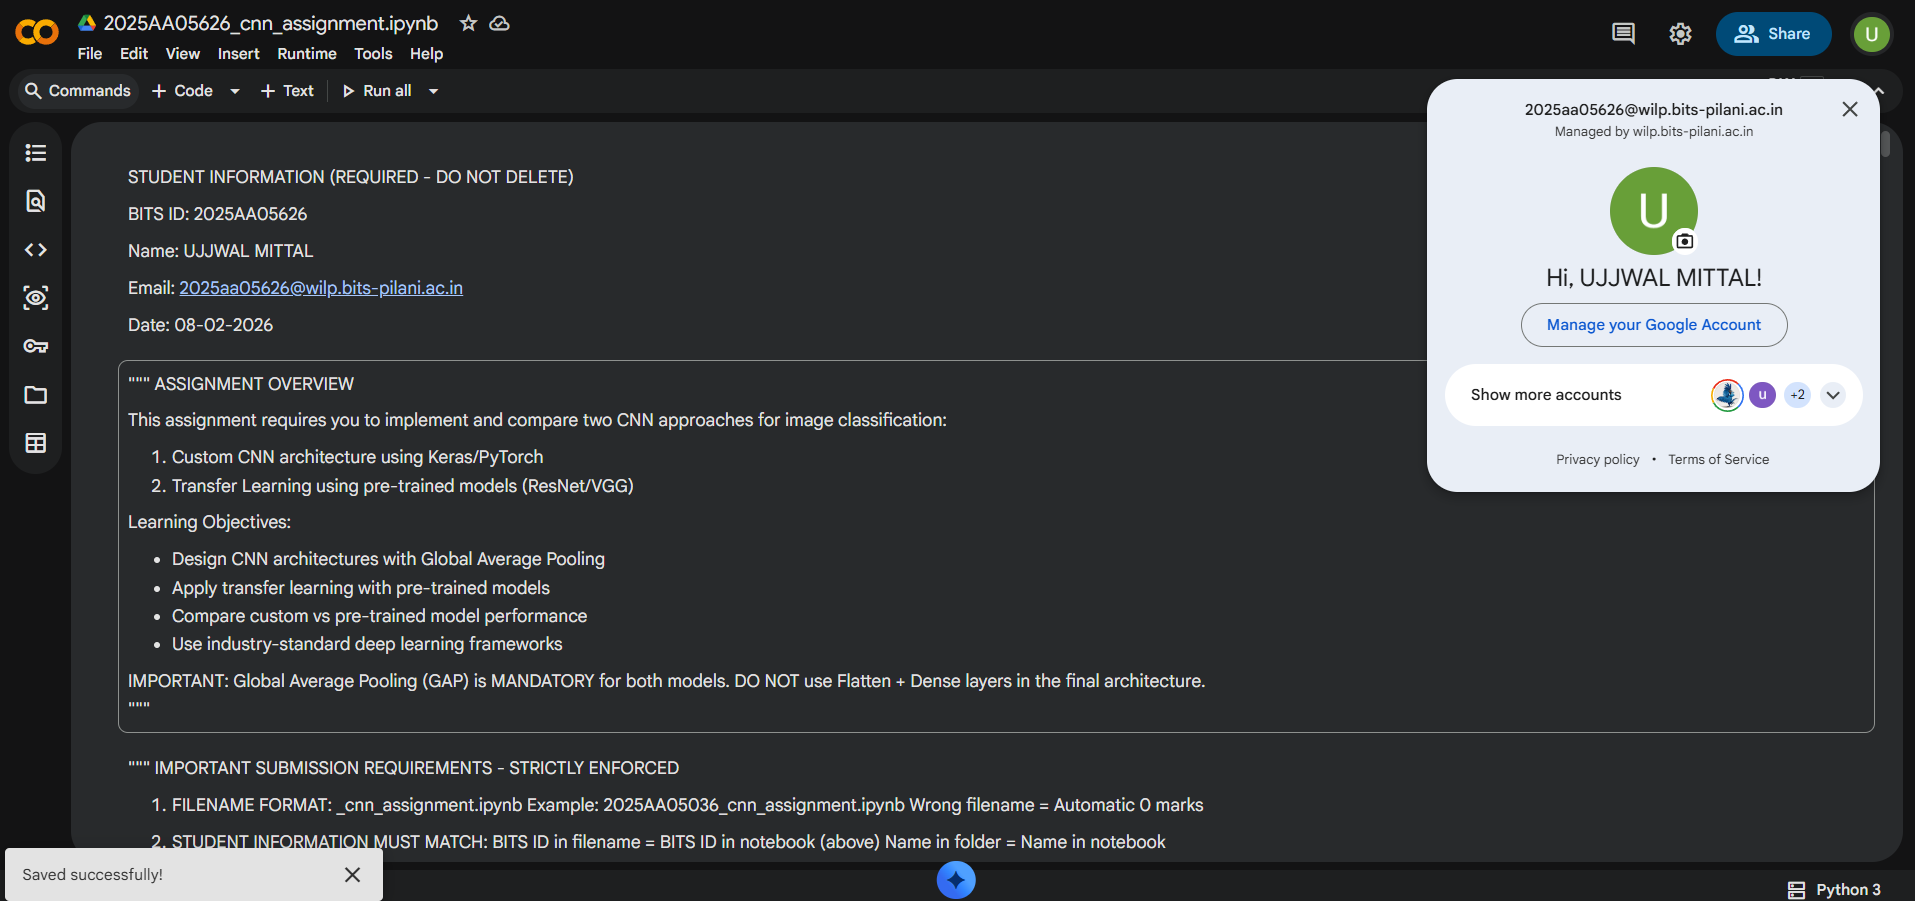